In [69]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [1]:
#import os
#os.chdir('/content/gdrive/My Drive/Daicon_PJ')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet, ElasticNetCV

### 1. Importing final data and EDA some variables

In [2]:
#path_dir = os.getcwd()+'/'
RSB_df = pd.read_csv('RSB_final.csv',na_values='-',encoding='utf8')
RSB_df.head()

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,...,SF,도실,루타,타석,희타,WAR,WOBA,WPA,WRC+,salary
0,1,강경학,2011,한화,0.000,2,1,0,0,0,...,0,0,0,1,0,0.01,0.000,NaN,NaN,0.0
1,1,강경학,2014,한화,0.221,41,86,11,19,2,...,0,0,30,103,2,0.21,0.316,-0.11,65.6,2400.0
2,1,강경학,2015,한화,0.257,120,311,50,80,7,...,3,3,101,376,18,0.11,0.304,-0.32,66.4,6500.0
3,1,강경학,2016,한화,0.158,46,101,16,16,3,...,1,0,26,116,4,-0.69,0.223,-1.10,10.5,6500.0
4,1,강경학,2017,한화,0.214,59,84,17,18,2,...,0,1,22,93,0,-0.16,0.264,-0.81,44.1,6200.0


In [3]:
reorder_list = ['batter_id', 'batter_name', 'year', 'team', 'age', 'posi', 'ta', 'salary', 'G', 'AB', 'R', 'H',
       '2B', '3B', 'HR', 'TB', 'RBI', 'SB', 'CS', 'BB', 'HBP', 'SO', 'GDP',
       'E', 'year_born', 'col_school', 'height', 'weight',
       '고4', 'SF', '도실', '루타', '타석', '희타', 'WAR', 'WOBA',
       'WPA', 'avg', 'WRC+','SLG', 'OBP', 'OPS']
RSB = RSB_df[reorder_list]
RSB.head()

,batter_id,batter_name,year,team,age,posi,ta,salary,G,AB,...,타석,희타,WAR,WOBA,WPA,avg,WRC+,SLG,OBP,OPS
0,1,강경학,2011,한화,19,내야수,좌타,0.0,2,1,...,1,0,0.01,0.000,NaN,0.000,NaN,0.000,0.000,0.000
1,1,강경학,2014,한화,22,내야수,좌타,2400.0,41,86,...,103,2,0.21,0.316,-0.11,0.221,65.6,0.349,0.337,0.686
2,1,강경학,2015,한화,23,내야수,좌타,6500.0,120,311,...,376,18,0.11,0.304,-0.32,0.257,66.4,0.325,0.348,0.673
3,1,강경학,2016,한화,24,내야수,좌타,6500.0,46,101,...,116,4,-0.69,0.223,-1.10,0.158,10.5,0.257,0.232,0.489
4,1,강경학,2017,한화,25,내야수,좌타,6200.0,59,84,...,93,0,-0.16,0.264,-0.81,0.214,44.1,0.262,0.290,0.552


#### 결측값이 많은 'col_school', 'WPA' 정리

- college : 대졸 선수 = 1, 고졸 & 용병 = 0으로 처리

- WPA : 결측값이 너무 많다... Delete!

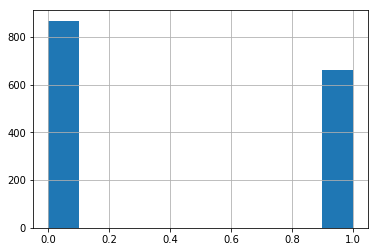

In [4]:
def is_colleged(x):
  if x is np.nan:
    x = 0
  else:
    x = 1
  return x
  
RSB['col_school'] = RSB['col_school'].map(lambda x: is_colleged(x)) # nan = 0으로 대체됨.
RSB['col_school'].hist()

In [6]:
#RSB.isna().sum()

In [7]:
RSB = RSB.drop(['WPA'], axis = 1) # WPA 변수 제거
#RSB.isna().sum()

#### (2) One-Hot encoding for categorical variables

- team, posi, ta에 대하여 one-hot encoding 필요

- team의 경우: 쌍방울 = **SK**, 해태 = **KIA**, (현대, 우리, 히어로즈, 넥센) = **키움**

In [8]:
RSB['team'] = RSB['team'].replace('쌍방울','SK').replace('해태','KIA').replace('현대','키움').replace('우리','키움').replace('히어로즈','키움').replace('넥센','키움')
RSB['team'].unique()

array(['한화', 'NC', '롯데', '삼성', 'KT', 'LG', 'SK', 'KIA', '키움', '두산'],
      dtype=object)

In [9]:
print(RSB['posi'].value_counts(),'\n',RSB['ta'].value_counts())

내야수    787
외야수    559
포수     185
Name: posi, dtype: int64 
 우타    995
좌타    523
양타     13
Name: ta, dtype: int64


In [10]:
dummies = pd.get_dummies(RSB[['team','posi','ta']])
RSB_plus_dummies = pd.concat([RSB, dummies], axis = 1, ignore_index = False)
RSB = RSB_plus_dummies.drop(['team','posi','ta'], axis = 1)
RSB.head()

,batter_id,batter_name,year,age,salary,G,AB,R,H,2B,...,team_롯데,team_삼성,team_키움,team_한화,posi_내야수,posi_외야수,posi_포수,ta_양타,ta_우타,ta_좌타
0,1,강경학,2011,19,0.0,2,1,0,0,0,...,0,0,0,1,1,0,0,0,0,1
1,1,강경학,2014,22,2400.0,41,86,11,19,2,...,0,0,0,1,1,0,0,0,0,1
2,1,강경학,2015,23,6500.0,120,311,50,80,7,...,0,0,0,1,1,0,0,0,0,1
3,1,강경학,2016,24,6500.0,46,101,16,16,3,...,0,0,0,1,1,0,0,0,0,1
4,1,강경학,2017,25,6200.0,59,84,17,18,2,...,0,0,0,1,1,0,0,0,0,1


In [35]:
regular = RSB

In [36]:
for j in a:
    lag_1_avg=[]
    for i in range(len(regular)): 
        if len(regular.loc[(regular['batter_name']==regular['batter_name'].iloc[i])&(regular['year']==regular['year'].iloc[i]-1)][j])==0:
            lag_1_avg.append(np.nan)
        else:
            lag_1_avg.append(regular.loc[(regular['batter_name']==regular['batter_name'].iloc[i])&(regular['year']==regular['year'].iloc[i]-1)][j].iloc[0])
    
    regular['lag_1_'+j]=lag_1_avg
    print(j)

salary
G
AB
R
H
2B
3B
HR
TB
RBI
SB
CS
BB
HBP
SO
GDP
E
year_born
col_school
height
weight
고4
SF
도실
루타
타석
희타
WAR
WOBA
avg
WRC+
SLG
OBP
OPS


In [33]:
 a =   ['salary', 'G', 'AB', 'R',
       'H', '2B', '3B', 'HR', 'TB', 'RBI', 'SB', 'CS', 'BB', 'HBP', 'SO',
       'GDP', 'E', 'year_born', 'col_school', 'height', 'weight', '고4', 'SF',
       '도실', '루타', '타석', '희타', 'WAR', 'WOBA', 'avg', 'WRC+', 'SLG', 'OBP',
       'OPS']

In [11]:
RSB.to_csv('RSB_final_df.csv', index = False, encoding = 'utf8')

In [37]:
RSB =regular

In [61]:
train_X.isna().sum()

year                0
age                 0
team_KIA            0
team_KT             0
team_LG             0
team_NC             0
team_SK             0
team_두산             0
team_롯데             0
team_삼성             0
team_키움             0
team_한화             0
posi_내야수            0
posi_외야수            0
posi_포수             0
ta_양타               0
ta_우타               0
ta_좌타               0
lag_1_salary        0
lag_1_G             0
lag_1_AB            0
lag_1_R             0
lag_1_H             0
lag_1_2B            0
lag_1_3B            0
lag_1_HR            0
lag_1_TB            0
lag_1_RBI           0
lag_1_SB            0
lag_1_CS            0
lag_1_BB            0
lag_1_HBP           0
lag_1_SO            0
lag_1_GDP           0
lag_1_E             0
lag_1_col_school    0
lag_1_height        0
lag_1_weight        0
lag_1_고4            0
lag_1_SF            0
lag_1_도실            0
lag_1_루타            0
lag_1_타석            0
lag_1_희타            0
lag_1_WAR           0
lag_1_WOBA

# 2.  Model Training과 Validation

#### (1) Train & Test split

- Training data : 2018년 **이전**의 기록들

- Test data : 2018년**의** 기록들

In [59]:
train_dt = RSB.loc[RSB['year'] <= 2017, ]
train_dt =train_dt[-train_dt['lag_1_G'].isna()]
test_dt = RSB.loc[RSB['year'] == 2018, ]
test_dt =test_dt[-test_dt['lag_1_G'].isna()]

train_batters = train_dt[['batter_id','batter_name']]
train_X = train_dt.drop(['batter_id','batter_name','lag_1_year_born'], axis = 1).drop(columns = a)
train_Y = train_dt['OPS']

test_batters = test_dt[['batter_id','batter_name']]
test_X = test_dt.drop(['batter_id','batter_name','lag_1_year_born'], axis = 1).drop(columns = a)
test_Y = test_dt['OPS']

#### (2) Random Forest modeling

- 최적의 n_tree 개수를 찾은 뒤 modeling에 사용하자 

In [62]:
real_OPS = test_Y
real_AB = test_dt['AB']
RF_ntree = list(range(500,5500,500))
acc = []
for param in RF_ntree:
  RF = RandomForestRegressor(n_estimators = param, max_features = int(train_X.shape[1]/3), random_state = 10)
  RF.fit(train_X.fillna(train_X['lag_1_WRC+'].median()), train_Y, sample_weight = train_dt['lag_1_AB'])
  rf_pred_OPS = RF.predict(test_X.fillna(train_X['lag_1_WRC+'].median()))
  rf_error = mean_squared_error(real_OPS, rf_pred_OPS, sample_weight = real_AB)
  acc.append(rf_error)
  print('n_trees: ', param, ', error: ', rf_error**(1/2))

n_trees:  500 , error:  0.012069439803542286
n_trees:  1000 , error:  0.011928496598132651
n_trees:  1500 , error:  0.011944074837380424
n_trees:  2000 , error:  0.011946153142261282
n_trees:  2500 , error:  0.011924953640733068
n_trees:  3000 , error:  0.011920793265991117
n_trees:  3500 , error:  0.011934663654073627
n_trees:  4000 , error:  0.01189529470649967
n_trees:  4500 , error:  0.011886788702930704
n_trees:  5000 , error:  0.011897122689043685


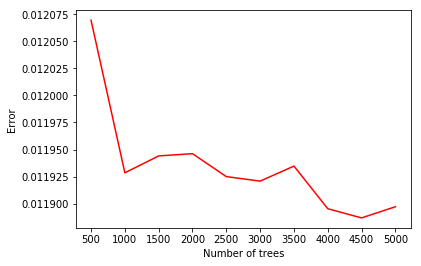

In [63]:
plt.figure()
plt.plot(RF_ntree, acc, 'r')
plt.xlabel('Number of trees')
plt.xticks(np.arange(500, 5500, step = 500))
plt.ylabel('Error')
plt.show()

- ntree = 1500일 때 최소의 test MSE를 보였으므로, 이것을 최종 Random forest 모형으로 사용하자.

In [65]:
RF_final = RandomForestRegressor(n_estimators = 4500, max_features = int(train_X.shape[1]/3))
RF_final.fit(train_X.fillna(train_X['lag_1_WRC+'].median()), train_Y)
rf_pred = RF_final.predict(test_X.fillna(train_X['lag_1_WRC+'].median()))
rf_error = mean_squared_error(real_OPS, rf_pred, sample_weight = real_AB)
print(rf_error)

0.012172552113846508


In [66]:
test_dt['yhat']=rf_pred

In [74]:
tmp = test_dt[['batter_name','AB','OPS','yhat']]
#display(tmp[tmp['batter_name']=='샌즈'])
tmp.shape

(177, 4)

In [72]:
train_X.columns[50]

'lag_1_OPS'

Feature ranking:
1. feature 44 (0.065749)
2. feature 50 (0.058621)
3. feature 18 (0.057315)
4. feature 27 (0.057082)
5. feature 45 (0.048583)
6. feature 47 (0.042163)
7. feature 49 (0.042070)
8. feature 48 (0.039852)
9. feature 26 (0.038378)
10. feature 41 (0.037635)
11. feature 37 (0.034466)
12. feature 0 (0.032407)
13. feature 36 (0.030365)
14. feature 25 (0.030084)
15. feature 32 (0.029800)
16. feature 19 (0.027888)
17. feature 42 (0.024681)
18. feature 22 (0.024185)
19. feature 1 (0.023961)
20. feature 20 (0.022775)
21. feature 46 (0.022682)
22. feature 30 (0.021148)
23. feature 21 (0.020306)
24. feature 23 (0.016756)
25. feature 43 (0.014283)
26. feature 31 (0.013385)
27. feature 34 (0.011434)
28. feature 33 (0.011156)
29. feature 28 (0.009824)
30. feature 29 (0.007814)
31. feature 40 (0.007785)
32. feature 4 (0.005795)
33. feature 7 (0.005716)
34. feature 11 (0.005610)
35. feature 39 (0.005455)
36. feature 35 (0.005008)
37. feature 14 (0.004892)
38. feature 24 (0.004719)
39. feat

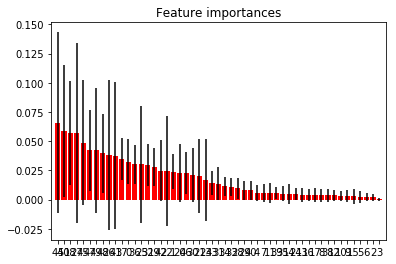

In [68]:
importances = RF_final.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF_final.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(train_X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
    plt.figure()
plt.title("Feature importances")
plt.bar(range(train_X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(train_X.shape[1]), indices)
plt.xlim([-1, train_X.shape[1]])
plt.show()

In [73]:
pd.DataFrame({'Variable':train_X.columns,
              'Importance':RF_final.feature_importances_}).sort_values('Importance', ascending=False)

,Variable,Importance
44,lag_1_WAR,0.065749
50,lag_1_OPS,0.058621
18,lag_1_salary,0.057315
27,lag_1_RBI,0.057082
45,lag_1_WOBA,0.048583
47,lag_1_WRC+,0.042163
49,lag_1_OBP,0.042070
48,lag_1_SLG,0.039852
26,lag_1_TB,0.038378
41,lag_1_루타,0.037635


In [33]:
train_X.fillna(train_X['WRC+'].median()).values

array([[2.011e+03, 1.900e+01, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [2.014e+03, 2.200e+01, 2.400e+03, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       [2.015e+03, 2.300e+01, 6.500e+03, ..., 0.000e+00, 0.000e+00,
        1.000e+00],
       ...,
       [2.015e+03, 2.600e+01, 2.800e+03, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [2.016e+03, 2.700e+01, 2.800e+03, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [2.017e+03, 2.800e+01, 2.800e+03, ..., 1.000e+00, 0.000e+00,
        0.000e+00]])

In [28]:
from xgboost.sklearn import XGBRegressor

model = XGBRegressor(silent=False,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='reg:linear', 
                      n_estimators=1500, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=10)
model.fit(train_X.fillna(train_X['WRC+'].median()), train_Y)
xgb_pred = model.predict(test_X.fillna(train_X['WRC+'].median()))
xgb_error = mean_squared_error(real_OPS, xgb_pred, sample_weight = real_AB)
print('Random forest error: ', rf_error, '\nXGBoost error: ', xgb_error)

Random forest error:  0.00018761665838616076 
XGBoost error:  0.013614801571554888


In [29]:
pd.DataFrame({'Variable':train_X.columns,
              'Importance':model.feature_importances_}).sort_values('Importance', ascending=False)

,Importance,Variable
32,0.393939,SLG
29,0.219697,WOBA
33,0.219697,OBP
31,0.090909,WRC+
28,0.037879,WAR
30,0.015152,avg
6,0.007576,H
10,0.007576,TB
11,0.007576,RBI
38,0.000000,team_SK


In [0]:
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import cross_val_score, cross_validate   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search
def modelfit(alg, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(train_X.fillna(train_X['WRC+'].median()).values, label=train_Y.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(train_X, train_Y, eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(test_X.fillna(train_X['WRC+'].median()))
        
    #Print model report:
    print("\nModel Report")
    print("WMSE : %.5g" % metrics.mean_squared_error(test_Y.values, dtrain_predictions, sample_weight = real_AB))
                    
    feat_imp = pd.DataFrame({'Variable':train_X.columns,
              'Importance':model.feature_importances_}).sort_values('Importance', ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 7.526e-05


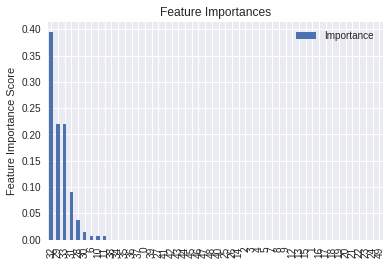

In [54]:
xgb1 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1500,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1)

#### (1) Tuning max_depth & min_child_weight

- best = **{'max_depth': 9, 'min_child_weight': 1}**

In [60]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(
    estimator = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1500,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27), 
 param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train_X, train_Y)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:1

({'mean_fit_time': array([ 7.03135419,  8.05303049,  8.50000882,  6.24012108,  7.32423892,
          9.7029151 ,  5.72236414,  7.68177171, 10.23068194,  5.78577471,
          8.0043993 ,  9.86657915]),
  'mean_score_time': array([0.0318449 , 0.04125872, 0.04061227, 0.02997141, 0.03595824,
         0.04056573, 0.0289012 , 0.03994827, 0.04859509, 0.02613721,
         0.03783216, 0.03608923]),
  'mean_test_score': array([-0.00347082, -0.00479752, -0.00364719, -0.00340505, -0.00486965,
         -0.00364542, -0.00343723, -0.00497667, -0.00360082, -0.00340357,
         -0.00495744, -0.00359179]),
  'mean_train_score': array([-3.22401131e-07, -3.91172854e-07, -8.78754627e-07, -2.32151790e-07,
         -2.46241653e-07, -2.76687348e-07, -2.06657938e-07, -2.25512924e-07,
         -2.48097982e-07, -1.86612338e-07, -2.08597845e-07, -2.31618536e-07]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, Fa

In [57]:
sorted(metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

In [61]:
param_test2 = {
 'max_depth':[8,9,10],
 'min_child_weight':[1,2,3]
}
gsearch2 = GridSearchCV(
    estimator = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1500,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27), 
 param_grid = param_test2, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train_X, train_Y)
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 9, 'min_child_weight': 1}, -0.0034035665884966475)

#### (2) Tuning gamma

- best =**{'gamma': 0.0}**

In [62]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(
    estimator = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1500,
 max_depth=9,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27), 
 param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train_X, train_Y)
gsearch3.cv_results_,gsearch3.best_params_, gsearch3.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:1

({'mean_fit_time': array([ 5.68988276, 27.52399068, 27.20346513, 27.42718101, 25.660148  ]),
  'mean_score_time': array([0.03038278, 0.01601205, 0.01924706, 0.01821761, 0.01245351]),
  'mean_test_score': array([-0.00340357, -0.00433341, -0.00479411, -0.00522734, -0.00559935]),
  'mean_train_score': array([-1.86612338e-07, -4.63370970e-04, -8.46321076e-04, -1.23571704e-03,
         -1.62663290e-03]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'rank_test_score': array([1, 2, 3, 4, 5], dtype=int32),
  'split0_test_score': array([-0.00068439, -0.00119236, -0.00159138, -0.00187954, -0.00220065]),
  'split0_train_score': array([-1.85176558e-07, -4.76150260e-04, -8.61587381e-04, -1.28977409e-03,
         -1.68678134e-03]),
  'split1_test_score': array([-0.000


Model Report
WMSE : 9.9294e-05


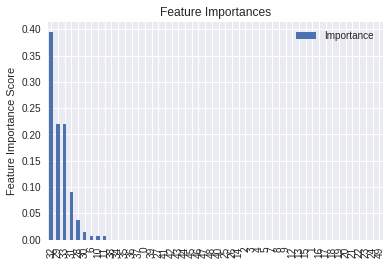

In [64]:
xgb2 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1500,
 max_depth=9,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2)

#### (3) Tuning subsample and colsample_bytree

In [66]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(
    estimator = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1500,
 max_depth=9,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27), 
 param_grid = param_test4, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train_X, train_Y)
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:1

({'mean_fit_time': array([6.31718988, 5.94155092, 5.27257991, 5.14806709, 7.17450385,
         5.78564153, 5.47564063, 5.24856057, 7.01043167, 6.25688601,
         5.73732166, 5.30340362, 7.83144698, 6.66027837, 6.02038326,
         5.32613001]),
  'mean_score_time': array([0.03190494, 0.02937455, 0.02291369, 0.02515821, 0.03326669,
         0.0279388 , 0.03020449, 0.02817826, 0.02707758, 0.02995386,
         0.02899981, 0.02524791, 0.02767377, 0.02764783, 0.02988992,
         0.01917629]),
  'mean_test_score': array([-0.00354533, -0.00354776, -0.00360799, -0.00381311, -0.00335387,
         -0.00337011, -0.00341348, -0.003846  , -0.00348545, -0.00347936,
         -0.00340357, -0.00376835, -0.00362348, -0.00340284, -0.00346838,
         -0.00348919]),
  'mean_train_score': array([-1.64572469e-07, -1.79909998e-07, -1.98295575e-07, -2.19214382e-07,
         -1.60023107e-07, -1.74891903e-07, -1.96157617e-07, -2.25242058e-07,
         -1.55880569e-07, -1.67942204e-07, -1.86612338e-07, -2.23

In [68]:
param_test5 = {
 'subsample':[i/100.0 for i in range(65,80,5)],
 'colsample_bytree':[i/100.0 for i in range(55,70,5)]
}
gsearch5 = GridSearchCV(
    estimator = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1500,
 max_depth=9,
 min_child_weight=1,
 gamma=0,
 subsample=0.6,
 colsample_bytree=0.7,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 seed=27), 
 param_grid = param_test5, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train_X, train_Y)
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:1

({'mean_fit_time': array([5.84828935, 5.51162467, 5.62470994, 5.8159987 , 6.00362697,
         5.44984484, 5.87342548, 5.62669821, 5.01236076]),
  'mean_score_time': array([0.03137684, 0.03838906, 0.02896881, 0.03335166, 0.02626319,
         0.02779379, 0.03304973, 0.0359591 , 0.01974154]),
  'mean_test_score': array([-0.00355915, -0.00367377, -0.00362445, -0.00359456, -0.00354776,
         -0.00355355, -0.00359134, -0.00348702, -0.00343908]),
  'mean_train_score': array([-1.76157265e-07, -1.81905539e-07, -1.91561987e-07, -1.70659566e-07,
         -1.79909998e-07, -1.88662800e-07, -1.68916512e-07, -1.77554579e-07,
         -1.86361743e-07]),
  'param_colsample_bytree': masked_array(data=[0.55, 0.55, 0.55, 0.6, 0.6, 0.6, 0.65, 0.65, 0.65],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_subsample': masked_array(data=[0.65, 0.7, 0.75, 0.65, 0.7, 0.75, 0.65, 0.7, 0.75],